# Subgroup and Instantaneous Fairness

This notebook demonstrates the usage of the subgroup fairness and instantaneous fairness post processing methods.

These methods are derived from the 'Fairness in Forecasting of Observations of Linear Dynamical Systems' paper by Quan Zhou, et al. The paper can be found at https://www.jair.org/index.php/jair/article/view/14050. 

Subgroup fairness and instantaneous fairness are two notions of fairness introduced to address under-representation bias when learning forecasting models from imbalanced time series data. 

**Subgroup fairness** seeks to equalize the total loss for each subgroup over the entire time period. The optimisation problem for subgroup fairness is as follows:

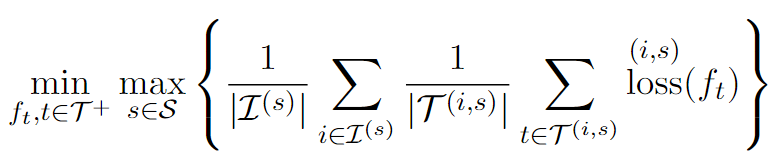

**Instantaneous fairness**, on the other hand, seeks to equalize the maximum instantaneous loss across all subgroups at each time step. The optimisation problem for instantaneous fairness is as follows:

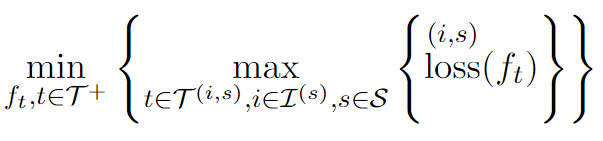

Both notions can be incorporated as constraints into an optimization problem to learn fair linear dynamical system models that predict future time series values while mitigating unfairness between advantaged and disadvantaged subgroups present in the training data.

In [1]:
# Load all necessary packages
import sys
sys.path.append("../")

import numpy as np
from tqdm import tqdm

from aif360.datasets import CompasDataset, BankDataset, AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
import load_preproc_data_compas, load_preproc_data_german, load_preproc_data_adult

from aif360.datasets import AdultDataset, GermanDataset, CompasDataset

import pandas as pd

from aif360.algorithms.postprocessing.instantaneous_fair import InstantaneousFairness
from aif360.algorithms.postprocessing.subgroup_fair import SubgroupFairness

import matplotlib.pyplot as plt
import matplotlib.text as mtext
        
import time

from tabulate import tabulate

C:\Users\01joh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


## Performance Measure

This function calculates various performance metrics based on the actual labels (`y_actual`) and predicted labels (`y_hat`).

- It initializes counters for true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN).
- It iterates over the predicted labels and compares them with the actual labels to update the counters accordingly.
- It calculates the following metrics:
  - NR: Negative rate, which is the proportion of negative instances in the dataset.
  - FPR: False positive rate, which is the proportion of negative instances incorrectly classified as positive.
  - FNR: False negative rate, which is the proportion of positive instances incorrectly classified as negative.
  - PPV: Positive predictive value, which is the proportion of true positive instances among all instances classified as positive.
  - NPV: Negative predictive value, which is the proportion of true negative instances among all instances classified as negative.
  - inACC: Inaccuracy, which is the total number of misclassifications (FP + FN).
- It returns a list containing the calculated metrics.

In [2]:
def perf_measure(y_actual, y_hat):
    TP = 0
    TN = 0
    FP = 0 
    FN = 0 
    
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==0:
            TP += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==1:
            TN += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FN += 1

    # NR is the negative rate
    NR =(TN+FN)/len(y_hat) 
    # FPR is the false positive rate
    FPR=FP/(FP+TN+10**(-6)) 
    # FNR is the false negative rate
    FNR=FN/(FN+TP+10**(-6))
    # PPV is the positive predictive value
    PPV=TP/(TP+FP+10**(-6)) 
    # NPV is the negative predictive value
    NPV=TN/(TN+FN+10**(-6)) 
    # inACC is the inaccuracy
    inACC=FP+FN 
    
    return [NR,FPR,FNR,PPV,NPV,inACC]

## Fair Metric

This function calculates fairness metrics for two subgroups (I0 and I1) based on their predicted scores and actual labels.

- It creates masks (`I0_mask` and `I1_mask`) to identify the instances belonging to each subgroup in the test dataset (`Dtest`).
- It determines the score thresholds (`th0` and `th1`) for each subgroup based on the provided `base_rate` or a single threshold (`thresh`).
- It extracts the actual labels and predicted scores for each subgroup using the masks and thresholds.
- It calculates the performance metrics for each subgroup using the `perf_measure` function.
- It computes the following fairness metrics:
  - IND: Independence, which is the absolute difference in negative rates between the two subgroups.
  - SP: Separation, which is the sum of the absolute differences in false positive rates and false negative rates between the subgroups.
  - SF: Sufficiency, which is the sum of the absolute differences in positive predictive values and negative predictive values between the subgroups.
  - INA: Inaccuracy, which is the total number of misclassifications across both subgroups divided by the total number of instances.
- It returns a list containing the calculated fairness metrics.

In [3]:
def fair_metric(Dtest_priv, Dtest_unpriv, score_name, thresh, base_rate, perf_field):
    th0 = base_rate[0]
    th1 = base_rate[1]
    # th0 = thresh
    # th1 = thresh
    y_actual_I0 = Dtest_priv[perf_field].tolist()
    y_hat_I0 = (Dtest_priv[score_name] >= th0).astype(int).tolist()
    y_actual_I1 = Dtest_unpriv[perf_field].tolist()
    y_hat_I1 = (Dtest_unpriv[score_name] >= th1).astype(int).tolist()
    perf_I0 = perf_measure(y_actual_I0, y_hat_I0)
    perf_I1 = perf_measure(y_actual_I1, y_hat_I1)
    IND = abs(perf_I0[0] - perf_I1[0])
    SP = abs(perf_I0[1] - perf_I1[1] + abs(perf_I1[2] - perf_I0[2]))
    SF = abs(perf_I0[3] - perf_I1[3] + abs(perf_I0[4] - perf_I1[4]))
    INA = (perf_I0[5] + perf_I1[5]) / (len(Dtest_priv) + len(Dtest_unpriv))
    return [IND, SP, SF, INA]

## Calculate Base Rate

This function calculates the base rates for two subgroups based on a protected attribute and predicted labels.

- It calculates `base0` as the proportion of instances with the protected attribute value of 1 and predicted label of 1.
- It calculates `base1` as the proportion of instances with the protected attribute value not equal to 1 and predicted label of 1.
- It returns a tuple containing `base0` and `base1`.

In [4]:
def calculate_base_rate(base_rate_dataframe):
    protectedB = protected_attributes_used[1]
    base0=(1-base_rate_dataframe.loc[(base_rate_dataframe[protectedB]==privileged_val) & (base_rate_dataframe[predict_col]==privileged_val), :].shape[0]/base_rate_dataframe.loc[base_rate_dataframe[protectedB]==privileged_val, :].shape[0])
    base1=(1-base_rate_dataframe.loc[(base_rate_dataframe[protectedB]!=privileged_val) & (base_rate_dataframe[predict_col]==privileged_val), :].shape[0]/ base_rate_dataframe.loc[base_rate_dataframe[protectedB]!=privileged_val, :].shape[0])
    return base0, base1

## Process Method

This function applies a fairness processing method to the dataset and updates the predicted scores.

- It initializes the fairness processing method (`pp`) based on the provided method name (`m`) and groups (`privileged_groups` and `unprivileged_groups`).
- It sets the optimization parameters for the fairness processing method, including the prediction column and attributes.
- It fits the fairness processing method to the validation dataset and predicted scores.
- It applies the fitted fairness processing method to the validation predicted scores to obtain the processed scores.
- It updates the test dataset (`Dtest`) with the processed scores for the corresponding method.


In [5]:
def process_method(m, Dtrain, Dtest, privileged_groups, unprivileged_groups, debug):
    pp = method_initializers[m](privileged_groups, unprivileged_groups, debug=debug)
    pp.set_optimisation_parameters(
        predict_col=predict_col,
        attr1=attr1,
        attr2=attr2,
        attr3=attr3
    )
    pp_fit = pp.fit(Dtrain)
    pp_scores_dataset = pp.predict(Dtest)
    pp_scores = pp_scores_dataset.labels
    score_indices = Dtest.index
    
    # Create a new DataFrame with the modified column
    Dtest_new = Dtest.copy()
    for i, j in enumerate(score_indices):
        Dtest_new.loc[j, m] = pp_scores[i]
    
    return Dtest_new

## Run Trials

This function runs multiple trials of the fairness evaluation process and collects performance and runtime metrics.

- It initializes empty lists to store the performance metrics (`metric_rows`) and runtime metrics (`metric_runtimes`) for each trial and method.
- It iterates over the specified number of trials.
  - For each trial, it sets a fixed random seed for reproducibility.
  - It splits the dataset into training, validation, and test sets using a 70-30 split.
  - It prepares the test dataset (`Dtest`) and applies the fairness processing methods to it using the `process_method` function.
  - It calculates the base rates for fairness metrics using the `calculate_base_rate` function.
  - It downsamples the privileged and unprivileged groups to ensure equal representation.
  - It evaluates the model performance and fairness metrics before and after reweighing using the `fair_metric` function.
  - It stores the performance metrics in the `metric_rows` list.
  - It stores the runtime of each method for each trial in the `metric_runtimes` list.
- It converts the collected metrics into DataFrames (`metric` and `metric_runtime`) for analysis and reporting.
- It returns the `metric` and `metric_runtime` DataFrames.

In [6]:
def run_trials(trials, methods, dataset_used, protected_attributes_used, debug, sample_size, test_train_split, thresh=[0.5]):
    metric_rows = []
    metric_runtimes = []

    for t in tqdm(range(trials)):
        np.random.seed(t)

        dataset_orig = dataset_loaders[dataset_used]()
        # print(dataset_orig.feature_names)
        # print(f"Dataset Rows: {dataset_orig.features.shape[0]}")
        
        dataset = dataset_orig.convert_to_dataframe()[0]
        #shuffle the dataset and sample the first 1200 rows
        dataset = dataset.sample(frac=1).reset_index(drop=True)
        dataset = dataset[:sample_size]
        #Dtrain is the first 80% of the dataset
        Dtrain = dataset[:int(test_train_split*len(dataset))]
        #Dtest is the last 20% of the dataset
        Dtest = dataset[int(test_train_split*len(dataset)):]
        for m in methods:
            time1 = time.time()
            Dtest = process_method(m, Dtrain, Dtest, privileged_groups, unprivileged_groups, debug)
            time2 = time.time()
            metric_runtimes.append({'method': m, 'runtime': time2 - time1, 'trial': t})

        #add another method to Dtest to compare the original model (no post-processing) to the post-processed models
        Dtest.loc[:, 'original'] = Dtest[predict_col].astype(int)
        
        base0, base1 = calculate_base_rate(dataset)

        Dtest_priv = Dtest[Dtest[protected_attributes_used[1]] == privileged_val]
        Dtest_unpriv = Dtest[Dtest[protected_attributes_used[1]] == unprivileged_val]

        len_rw = min(len(Dtest_priv), len(Dtest_unpriv))
        Dtest_priv_rw = Dtest_priv.sample(n=len_rw, random_state=1)
        Dtest_unpriv_rw = Dtest_unpriv.sample(n=len_rw, random_state=1)
        Dtest_rw = pd.concat([Dtest_priv_rw, Dtest_unpriv_rw])

        #print the counts of each value in Dtest[instantaneous-fair]
        #e.g. 0.0    100, 1.0    100
        # print(f"Base Rate: {base0}, {base1}")
        # print(f"Dtest instantaneous-fair counts: {Dtest['instantaneous-fair'].value_counts()}")
        # print(f"Dtest subgroup-fair counts: {Dtest['subgroup-fair'].value_counts()}")

        for threshold in thresh:
            for m in methods+['original']:
                model_perf = fair_metric(Dtest_priv, Dtest_unpriv, m, threshold, [base0, base1], predict_col)
                model_perf_rw = fair_metric(Dtest_priv_rw, Dtest_unpriv_rw, m, threshold, [base0, base1], predict_col)
                new_row = {'IND': model_perf[0], 'SP': model_perf[1], 'SF': model_perf[2], 'INA': model_perf[3],
                           'INDrw': model_perf_rw[0], 'SPrw': model_perf_rw[1], 'SFrw': model_perf_rw[2], 'INArw': model_perf_rw[3],
                           'type': m, 'thresh': threshold, 'trial': t}
                metric_rows.append(new_row)

    metric = pd.DataFrame(metric_rows)
    metric_runtime = pd.DataFrame(metric_runtimes)
    return metric, metric_runtime

## Datasets and Methods
Used to set the methods used to load the datasets and the fairness processing methods.

In [7]:
def load_compas_dataset():
    def custom_preprocessing(df):
        # Apply the filtering condition
        df = df[(df.days_b_screening_arrest <= 30) & (df.days_b_screening_arrest >= -30) & (df.is_recid != -1) & (df.c_charge_degree != 'O') & (df.score_text != 'N/A')]
        
        # Create a new DataFrame with the modified columns
        df_new = df.copy()
        
        # Summing the relevant counts into a new column
        df_new['priors_total_count'] = (df['juv_fel_count'] + df['juv_misd_count'] + df['priors_count']) / 3
        
        # 1 if the age is under 25, 0 otherwise
        df_new["age_under_25"] = (df["age"] < 25).astype(int)
        
        return df_new

    compas = CompasDataset(
        label_name=predict_col,
        favorable_classes=[1,1],
        protected_attribute_names=protected_attributes_used,
        privileged_classes=privileged_classes,
        instance_weights_name=None,
        categorical_features=categorical_feature_list,
        features_to_keep=features_to_keep,
        na_values=[],
        custom_preprocessing=custom_preprocessing,
        metadata={'protected_attribute_maps': [{0.0: 'Male', 1.0: 'Female'}, {1.0: 'Caucasian', 0.0: 'Not Caucasian'}]}
    )

    return compas

def load_adult_dataset():
    def custom_preprocessing(df):
        def group_race(x):
            if x == "White":
                return 1.0
            else:
                return 0.0

        df['race'] = df['race'].apply(lambda x: group_race(x))

        # Encode 'sex' column as numerical values
        df['sex'] = df['sex'].map({'Female': 0.0, 'Male': 1.0})

        df['Income Binary'] = df['income-per-year']
        df['Income Binary'] = df['Income Binary'].replace(to_replace='>50K.', value=1, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='<=50K.', value=0, regex=True)

        df['age_under_40'] = (df['age'] < 40).astype(int)        

        # print(df.columns)

        return df

    adult = AdultDataset(
        label_name=predict_col,
        favorable_classes=[1,1],
        protected_attribute_names=protected_attributes_used,
        privileged_classes=privileged_class_vals,
        instance_weights_name=None,
        categorical_features=categorical_feature_list,
        features_to_keep=features_to_keep,
        na_values=[],
        custom_preprocessing=custom_preprocessing,
        features_to_drop=[],
        metadata={}
    )
    return adult

In [8]:
dataset_loaders = {
    "compas": load_compas_dataset,
    "adult" : load_adult_dataset
}

method_initializers = {
    "subgroup-fair": SubgroupFairness,
    "instantaneous-fair": InstantaneousFairness
}



## Setting Parameters

- `dataset_used` sets the dataset to be used for the fairness evaluation process.
- `perf_field` is the field used to calculate the performance metrics.
- `protected_attribute_used` is the protected attribute used for fairness evaluation.
- `privileged_groups` and `unprivileged_groups` are the groups used for fairness evaluation, based on the protected attribute.
- `predictor_attribute` is the attribute used for prediction of the model.  
- `feature1`, `feature2`, and `feature3` are the attributes used for the fairness processing methods. Each consists of the feature name, the lower bound, and the upper bound used to filter the dataset. If a bound is not  needed, it is set to `None`.
- `trials` is the number of trials to run for the fairness evaluation process.
- `methods` is a list of fairness processing methods to evaluate.

In [9]:
dataset_used = "compas"
predict_col = "is_recid"
protected_attributes_used = ['sex','race']
privileged_classes = [['Female'], ['Caucasian']]
privileged_class_vals = [[1.0], [1.0]]
categorical_feature_list=['age_cat', 'c_charge_degree']
features_to_keep=['sex', 'age', 'age_cat', 'race','c_charge_degree', 'decile_score',
        # 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
        'priors_total_count','age_under_25']
privileged_val = 1
predictor_attribute = 'decile_score'
attr1 = "age_under_25"
attr2 = "priors_total_count"
attr3 = "decile_score"

unprivileged_val = 1 - privileged_val
privileged_groups = [{protected_attributes_used[1]: privileged_val}]
unprivileged_groups = [{protected_attributes_used[1]: unprivileged_val}]

methods = [
            'subgroup-fair',
            'instantaneous-fair'
            ]
            
debug = False
# thresh = [0.5]
thresh=[0.2,0.3,0.4,0.5,0.6,0.7,0.8]

trials = 3
sample_size = 1000
test_train_split = 0.8

metric_results_COMPAS, runtime_results_COMPAS = run_trials(trials, methods, dataset_used, protected_attributes_used, debug, sample_size, test_train_split,thresh)



  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\01joh\OneDrive\Desktop\Masters\AIF360\examples\..\aif360\algorithms\postprocessing\lds_baseclass.py:73: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  D_test.labels = scores
C:\Users\01joh\AppData\Local\Temp\ipykernel_13648\682255875.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dtest.loc[j, m] = pp_scores[i]
  0%|          | 0/3 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
#Demo parameters for Adult dataset
dataset_used = "adult"
predict_col = "Income Binary"
protected_attributes_used = ['sex','race']
privileged_classes = [['Male'], ['White']]
privileged_class_vals = [[1.0], [1.0]]
categorical_feature_list=[]
features_to_keep=['hours-per-week','capital-gain','age','age_under_40','education-num','sex','race','Income Binary']
privileged_val = 1
predictor_attribute = 'fnlwgt'
attr1 = "age_under_40"
attr2 = "education-num"
attr3 = "hours-per-week"

unprivileged_val = 1 - privileged_val
privileged_groups = [{protected_attributes_used[1]: privileged_val}]
unprivileged_groups = [{protected_attributes_used[1]: unprivileged_val}]

methods = [
            'subgroup-fair',
            'instantaneous-fair'
            ]
            
debug = False
# thresh = [0.5]
thresh=[0.2,0.3,0.4,0.5,0.6,0.7,0.8]

trials = 3
sample_size = 1000
test_train_split = 0.8

metric_results_adult, runtime_results_adult = run_trials(trials, methods, dataset_used, protected_attributes_used, debug, sample_size, test_train_split,thresh) 


  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\01joh\OneDrive\Desktop\Masters\AIF360\examples\..\aif360\algorithms\postprocessing\lds_baseclass.py:73: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  D_test.labels = scores
C:\Users\01joh\AppData\Local\Temp\ipykernel_51412\682255875.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dtest.loc[j, m] = pp_scores[i]
C:\Users\01joh\AppData\Local\Temp\ipykernel_51412\682255875.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

KeyboardInterrupt: 

In [ ]:

metric_results = {'compas': metric_results_COMPAS, 'adult': metric_results_adult}
runtime_results = {'compas': runtime_results_COMPAS, 'adult': runtime_results_adult}

## Graphing Performance Metric Results

Plots the performance metrics for each fairness processing method across multiple trials.

The following metrics are plotted:
- **IND**: Independence, which is the absolute difference in negative rates between the two subgroups.
- **SP**: Separation, which is the sum of the absolute differences in false positive rates and false negative rates between the subgroups.
- **SF**: Sufficiency, which is the sum of the absolute differences in positive predictive values and negative predictive values between the subgroups.
- **INA**: Inaccuracy, which is the total number of misclassifications across both subgroups divided by the total number of instances.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.text as mtext
import numpy as np
import pandas as pd

class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, orig_handle, **self.text_props)
        handlebox.add_artist(title)
        return title

performance = ['IND', 'SP', 'SF', 'INA']
performance1 = np.array([[i, i+'rw'] for i in performance]).flatten().tolist()
performance2 = np.array([[i+'rw'] for i in performance]).flatten().tolist()
colors = ['r', 'orange', 'c', 'g', 'b', 'm', 'y', 'k']

datasets = metric_results.keys()
fig, axs = plt.subplots(len(datasets), 2, figsize=(12, 6*len(datasets)), gridspec_kw={'height_ratios': [1, 1]})
min_val = float('inf')
max_val = float('-inf')

for idx, dataset in enumerate(datasets):
    metric_results[dataset][['type', 'thresh', 'trial']] = metric_results[dataset][['type', 'thresh', 'trial']].astype("category")
    pivot = pd.pivot_table(metric_results[dataset], index=['type', 'thresh'], values=performance1, aggfunc=["mean", "std"],observed=False)
    
    ind = np.arange(4)
    width = 0.15
    i = 0
    for m in ['original']+methods:
        sub1 = [pivot[('mean', p)][(m, 0.5)] for p in performance]
        sub1_std = [pivot[('std', p)][(m, 0.5)] for p in performance]
        axs[idx, 0].bar(ind+width*i, sub1, width, alpha=0.5, color=colors[i], label=m)
        axs[idx, 0].errorbar(ind+width*i, sub1, yerr=sub1_std, fmt='none', ecolor=colors[i], capsize=5, linestyle='--')

        sub = [pivot[('mean', p+'rw')][(m, 0.5)] for p in performance]
        sub_std = [pivot[('std', p+'rw')][(m, 0.5)] for p in performance]
        axs[idx, 1].bar(ind+width*i, sub, width, alpha=0.5, color=colors[i], label=m)
        axs[idx, 1].errorbar(ind+width*i, sub, yerr=sub_std, fmt='none', ecolor=colors[i], capsize=5, linestyle='-')

        i += 1
        
    axs[idx, 0].set_xlabel('Indices', fontsize=14)
    axs[idx, 0].set_ylabel('Values', fontsize=14)
    axs[idx, 0].set_xticks(ind+2*width)  
    axs[idx, 0].set_xticklabels([i for i in performance], fontsize=12)
    axs[idx, 0].tick_params(axis='y', which='major', labelsize=10)
    axs[idx, 0].set_title(dataset.capitalize() + ' (Original)', fontsize=12)
    axs[idx, 0].grid(axis='y')

    axs[idx, 1].set_xlabel('Indices', fontsize=14)
    axs[idx, 1].set_ylabel('Values', fontsize=14)
    axs[idx, 1].set_xticks(ind+2*width)  
    axs[idx, 1].set_xticklabels([i for i in performance], fontsize=12)
    axs[idx, 1].tick_params(axis='y', which='major', labelsize=10)
    axs[idx, 1].set_title(dataset.capitalize() + ' (Reweighted)', fontsize=12)
    axs[idx, 1].grid(axis='y')
    
    # Find the minimum and maximum values across all subplots
    min_val = min(min_val, axs[idx, 0].get_ylim()[0], axs[idx, 1].get_ylim()[0])  
    max_val = max(max_val, axs[idx, 0].get_ylim()[1], axs[idx, 1].get_ylim()[1])
    
# Calculate the y-axis limits based on the minimum and maximum values
margin = 0.05 * (max_val - min_val)
y_min = min_val - margin
y_max = max_val + margin

# Set the y-axis limits for all subplots
for idx in range(len(datasets)):
    axs[idx, 0].set_ylim(y_min, y_max)
    axs[idx, 1].set_ylim(y_min, y_max)
    
# Add a legend
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), fontsize=12)
    
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top spacing to make room for the legend
plt.show()

## Graphing Runtime Metric Results

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 12))

max_val = 0

width = 0.35
ind = np.arange(len(methods))

for idx, dataset in enumerate(datasets):
    pivot_runtime = pd.pivot_table(runtime_results[dataset], index=['method'], values=['runtime'], aggfunc=['mean', 'std'], observed=False)
    sub = [pivot_runtime[('mean', 'runtime')][m] for m in methods]
    sub1 = [pivot_runtime[('std', 'runtime')][m] for m in methods]
    ax1.bar(ind + idx * width, sub, width, yerr=sub1, alpha=0.5, color=colors[idx], label=dataset)
    
    max_val = max(max_val, max(sub)+max(sub1))

y_min = 0
y_max = max_val * 1.05



ax1.set_ylim(y_min, y_max)
ax1.set_xlabel('Methods', fontsize=16)
ax1.set_ylabel('Runtime (s)', fontsize=16)
ax1.set_xticks(ind + width / 2)
ax1.set_xticklabels(methods, fontsize=14, rotation=90)
ax1.tick_params(axis='y', which='major', labelsize=14)

ax1.legend(fontsize=14)

ax1.set_title('Runtime Comparison', fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
subgroup_quan = {'avg': 6.1, 'upper': 6.5, 'lower': 5.9}
subgroup_new = {'avg': 5.2, 'upper': 7.5, 'lower': 3.2}
instantaneous_quan = {'avg': 3.1, 'upper': 3.2, 'lower': 3.0}
instantaneous_new = {'avg': 5.2, 'upper': 8.1, 'lower': 3.0}

# Create lists for the data
labels = ['Subgroup', 'Instantaneous']
quan_avgs = [subgroup_quan['avg'], instantaneous_quan['avg']]
new_avgs = [subgroup_new['avg'], instantaneous_new['avg']]
quan_err = [[subgroup_quan['lower'] - quan_avgs[0], subgroup_quan['upper'] - quan_avgs[0]],
            [instantaneous_quan['lower'] - quan_avgs[1], instantaneous_quan['upper'] - quan_avgs[1]]]
new_err = [[subgroup_new['lower'] - new_avgs[0], subgroup_new['upper'] - new_avgs[0]],
           [instantaneous_new['lower'] - new_avgs[1], instantaneous_new['upper'] - new_avgs[1]]]

# Set the width of the bars
width = 0.35

# Set the positions of the bars on the x-axis
x = np.arange(len(labels))

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the bars
quan_bars = ax.bar(x - width/2, quan_avgs, width, label='Ncpol2sdpa', color='b', alpha=0.5, yerr=np.abs(quan_err), capsize=5)
new_bars = ax.bar(x + width/2, new_avgs, width, label='CVXPY', color='r', alpha=0.5, yerr=np.abs(new_err), capsize=5)

# Add labels and title
ax.set_ylabel('Run Time (s)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()